# Timeseries Forecasting
## Forecasting Sales for different stores
This Notebook will walk through a simple example use case that will forecast Sales for various stores

In [1]:
import datarobot as dr
from datarobot import Project, Deployment
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np

import datetime as dt
from datetime import datetime
import dateutil.parser
import os
import re 
from importlib import reload

## Connect to DataRobot API
You can enter your Token and Endpoint directly in the Notebook, or use a YAML file

In [2]:
# dr.Client(token='<API TOKEN>', endpoint='https://<YOUR ENDPOINT>/api/v2/')
# Or
dr.Client(config_path='../../../drconfig.yaml');

## Read in Dataset

In [3]:
df = pd.read_csv('./data/DR_Demo_Sales_Multiseries_training.csv',
                 infer_datetime_format=True,
                 parse_dates=['Date'],
                 engine='c'
                 )

df.head(5)

,Store,Date,Sales,Store_Size,Num_Employees,Num_Customers,Returns_Pct,Pct_On_Sale,Pct_Promotional,Marketing,TouristEvent,Econ_ChangeGDP,EconJobsChange,AnnualizedCPI
0,Louisville,2012-07-01,109673,20100,68,531,1.03,9.96,0.000047,July In Store Credit Card Signup Discount; In ...,No,0.5,NaN,0.02
1,Louisville,2012-07-02,131791,20100,34,476,0.41,8.65,0.000047,July In Store Credit Card Signup Discount; In ...,No,NaN,NaN,NaN
2,Louisville,2012-07-03,134711,20100,42,578,0.31,8.96,0.000047,July In Store Credit Card Signup Discount; In ...,No,NaN,NaN,NaN
3,Louisville,2012-07-04,97640,20100,54,569,0.83,10.08,0.000047,July In Store Credit Card Signup Discount; In ...,No,NaN,NaN,NaN
4,Louisville,2012-07-05,129538,20100,62,486,0.51,9.80,0.000047,July In Store Credit Card Signup Discount; ID5...,No,NaN,NaN,NaN


## Plot the Sales for each store

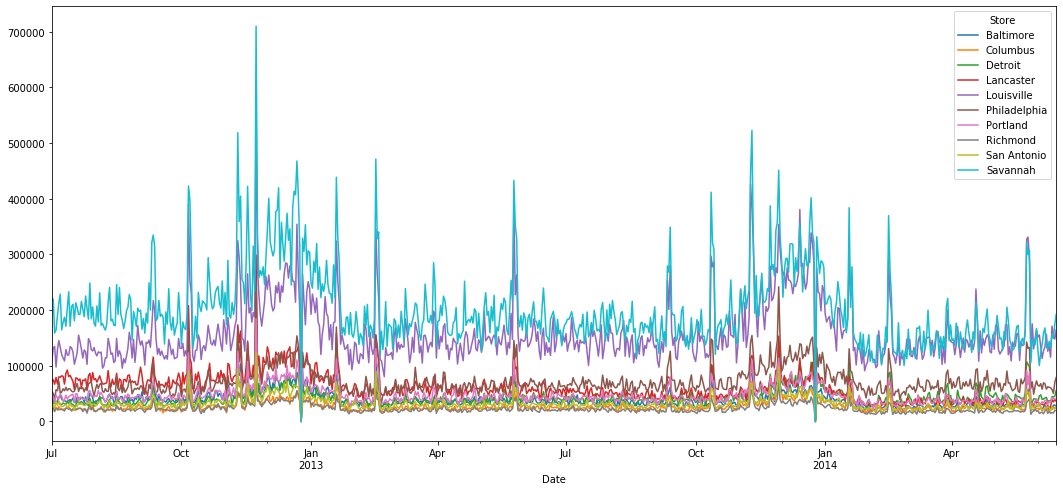

In [5]:
df.pivot(index='Date', columns='Store', values='Sales').plot(figsize=(18, 8));

## Create TS Settings
Set variables for Forecast Distance (FD), Feature Derivation Window (FDW), Project Name, Date, Target, Series Identifier, Known In Advance (KIA), and Calendar file. 

In [6]:
# Defaults
HOLDOUT_START_DATE  = None # pd.to_datetime('2014-04-12')
HOLDOUT_DURATION    = None # dr.helpers.partitioning_methods.construct_duration_string(years=0, months=0, days=64)   

# Known In Advance columns
KIA_VARS   = ['Store_Size', 'Marketing', 'TouristEvent']

FEATURE_SETTINGS = []
for column in KIA_VARS:
    FEATURE_SETTINGS.append(dr.FeatureSettings(column, known_in_advance=True, do_not_derive=False))
    
# Add Calendar file
CAL = dr.CalendarFile.create('./data/Calendar.csv',
                              calendar_name = 'Holiday_Calendar')

CAL_ID = CAL.id

print(FEATURE_SETTINGS)
print(' ')
print(CAL_ID)


[FeatureSettings(feature_name='Store_Size', known_in_advance=True, do_not_derive=False), FeatureSettings(feature_name='Marketing', known_in_advance=True, do_not_derive=False), FeatureSettings(feature_name='TouristEvent', known_in_advance=True, do_not_derive=False)]
 
5fcfea0344a14e332935e99f


## Set Time Partition
In the cell below we will set up our Date Time partionioning
This is where we specify the Date and Series ID fields, along with the Calendar ID and any Feature settings such as Known in Advance (KIA)

In [7]:
time_partition = dr.DatetimePartitioningSpecification(
    use_time_series           = True,
    datetime_partition_column = 'Date',
    multiseries_id_columns    = ['Store'],
    feature_settings          = FEATURE_SETTINGS,
    calendar_id               = CAL_ID
  )

## Create Project in DataRobot
In the cell below we will create the project inside DataRobot. This will upload our dataset and set our Project name along with the dataset name. 

In [8]:
project = dr.Project.create(
    project_name = 'Sales_Forecast', 
    sourcedata   = df, 
    dataset_filename = 'Sales_Multiseries_training.csv'
)

## Start Autopilot
Now we will start the project using Quick mode, with our Time Series partitioning specifications. 

In [9]:
project.set_target(
        target = 'Sales',      
        mode   = dr.AUTOPILOT_MODE.QUICK , # dr.AUTOPILOT_MODE.FULL_AUTO,
        partitioning_method = time_partition,
        worker_count = -1   # Use All Available workers
    )

Project(Sales_Forecast)

## Get Leaderboard
Once the project has completed we can pull the results from the Leaderboard. 
The cell below contains code to pull the Blueprints, along with the scores for each, and puts them in a Pandas dataframe called "scores"

In [20]:
models = []
scores = pd.DataFrame()

lb = project.get_datetime_models()
best_models = sorted(
                    [model for model in lb if model.metrics[project.metric]['backtesting']],  
                    key=lambda m: m.metrics[project.metric]['backtesting'],
                    )

for m in best_models:

    backtest_scores = pd.DataFrame(
        [
            {
                'Project_Name': project.project_name,
                'Project_ID': project.id,
                'Model_ID': m.id,
                'Model_Type': m.model_type,
                'Featurelist': m.featurelist_name,
                'Optimization_Metric': project.metric,
                'Scores': m.metrics,
            }
        ]
    )
    scores = scores.append(backtest_scores, sort=False).reset_index(drop=True)  


scores = scores.join(json_normalize(scores["Scores"].tolist())).drop(labels=['Scores'], axis=1) 

# Drop Empty Columns
scores = scores[scores.columns.drop(list(scores.filter(regex='crossValidation$')))]

# Rename Columns
scores.columns = scores.columns.str.replace(".backtesting", "_All_BT")
scores.columns = scores.columns.str.replace(".holdout", "_Holdout")
scores.columns = scores.columns.str.replace(".validation", "_BT_1")
scores.columns = scores.columns.str.replace(' ', '_')

scores = scores[scores.columns.drop(list(scores.filter(regex='_All_BTScores$')))]

# Filter down Accuracy Metrics 
METRICS = scores.filter(regex='MASE|RMSE').columns.to_list()
PROJECT = ['Project_Name', 'Project_ID', 'Model_ID', 'Model_Type', 'Featurelist']
COLS = PROJECT + METRICS
scores = scores[COLS]

scores

,Project_Name,Project_ID,Model_ID,Model_Type,Featurelist,MASE_All_BT,MASE_Holdout,MASE_BT_1,RMSE_All_BT,RMSE_Holdout,RMSE_BT_1
0,Sales_Forecast,5fcfea0fb39bd5561be4d82a,5fcfed63e7d88e693050579d,eXtreme Gradient Boosted Trees Regressor with ...,DR Reduced Features M12,0.54398,None,0.56029,15255.63200,None,11038.48119
1,Sales_Forecast,5fcfea0fb39bd5561be4d82a,5fcfebefea224dba8b4a4b88,eXtreme Gradient Boosted Trees Regressor with ...,With Differencing (average baseline),0.55200,None,0.54670,15592.45494,None,10644.03248
2,Sales_Forecast,5fcfea0fb39bd5561be4d82a,5fcfebf0ea224dba8b4a4b93,Ridge Regressor with Forecast Distance Modelin...,No Differencing,0.54041,None,0.50799,15703.12970,None,9745.29616
3,Sales_Forecast,5fcfea0fb39bd5561be4d82a,5fcfebf1ea224dba8b4a4b99,Ridge Regressor with Forecast Distance Modelin...,With Differencing (7 day),0.53933,None,0.51839,15703.76760,None,9908.03051
4,Sales_Forecast,5fcfea0fb39bd5561be4d82a,5fcfebf0ea224dba8b4a4b8c,Ridge Regressor with Forecast Distance Modelin...,With Differencing (latest),0.54682,None,0.49877,16220.08539,None,9639.44156


## Get the Best Model

In [24]:
hrmse = scores.loc[scores['RMSE_All_BT'].notnull()]

# Take the Single Best model
best_model = pd.DataFrame(hrmse.loc[hrmse.RMSE_All_BT.idxmin()]).transpose()
best_model

,Project_Name,Project_ID,Model_ID,Model_Type,Featurelist,MASE_All_BT,MASE_Holdout,MASE_BT_1,RMSE_All_BT,RMSE_Holdout,RMSE_BT_1
0,Sales_Forecast,5fcfea0fb39bd5561be4d82a,5fcfed63e7d88e693050579d,eXtreme Gradient Boosted Trees Regressor with ...,DR Reduced Features M12,0.54398,None,0.56029,15255.6,None,11038.5


## Generate Predictions
Lets grab the Best Model from the leaderboard that we have in the best_model dataframe. 
From here we upload our prediction dataset, compute the predictions, then download as a pandas dataframe when complete

In [28]:
PID = best_model['Project_ID'].values[RECORD]
MID = best_model['Model_ID'].values[RECORD]

project = dr.Project.get(PID)
model   = dr.Model.get(PID, MID)

dataset = project.upload_dataset('./data/DR_Demo_Sales_Multiseries_prediction.csv')

pred_job = model.request_predictions(dataset_id = dataset.id)

preds = pred_job.get_result_when_complete()

preds.head(5)

,series_id,forecast_point,row_id,timestamp,forecast_distance,prediction
0,Louisville,2014-06-14T00:00:00.000000Z,50,2014-06-15T00:00:00.000000Z,1,156708.373605
1,Louisville,2014-06-14T00:00:00.000000Z,51,2014-06-16T00:00:00.000000Z,2,147010.605050
2,Louisville,2014-06-14T00:00:00.000000Z,52,2014-06-17T00:00:00.000000Z,3,134462.925363
3,Louisville,2014-06-14T00:00:00.000000Z,53,2014-06-18T00:00:00.000000Z,4,134462.925363
4,Louisville,2014-06-14T00:00:00.000000Z,54,2014-06-19T00:00:00.000000Z,5,134462.925363
